<a href="https://colab.research.google.com/github/aaron-v19/practice/blob/main/pytorch_custom_datasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [183]:
#Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'


## 1.  Get Data

Our dataset is a subset of food101 dataset.

our dataset starts with 3 classes of 1000 images( 750 train, 250 test)



In [184]:
import requests
import zipfile
from pathlib import Path
# Setup a path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#if the image folder doesn't exist , download and prepare it

if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    print(f"Did not find {image_path}, creating one ....")
    image_path.mkdir(parents=True,exist_ok=True)

#Download pizza ,steak sushi
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request= requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza,steak,sushi")
    f.write(request.content)

#unzip file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza,steak and sushi data . . .")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists
Unzipping pizza,steak and sushi data . . .


In [185]:
# 2. Data preparation and data exploration
import os

def walk_through_dir(dir_path):
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [186]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.


In [187]:
train_dir=image_path/ "train"
test_dir=image_path/"test"

In [188]:
image_path

PosixPath('data/pizza_steak_sushi')

data/pizza_steak_sushi/train/sushi/773725.jpg
sushi
Image Class: sushi
Image height: 512
Image width: 382
Image format: JPEG


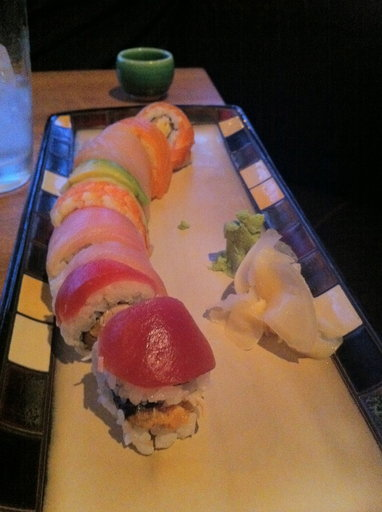

In [189]:
import random
from PIL import Image

#torch.manual_seed(42)

#1. Get all Image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))

#2. Pick a random image path
random_image_path=random.choice(image_path_list)
print(random_image_path)

#3. Get image class from path name
image_class=random_image_path.parent.stem
print(image_class)

#4. Print image
img=Image.open(random_image_path)

#5. print metadata
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image format: {img.format}")
img

#2. Visualize data

(-0.5, 381.5, 511.5, -0.5)

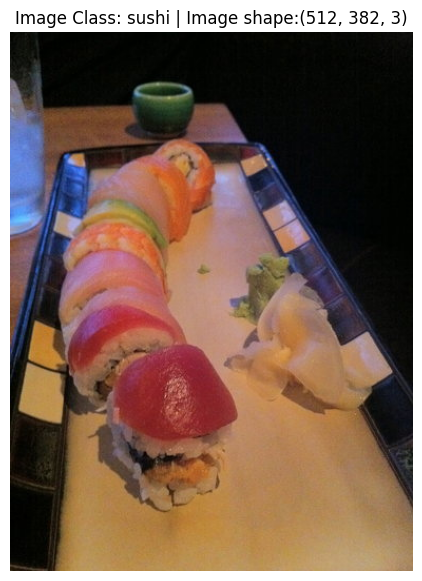

In [190]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array=np.asarray(img)

#Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape:{img_as_array.shape}")
plt.axis(False)

# 3.Transformig Data
 * Turn your data into tensors
 * Turn  it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [191]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

###3.1 Transforming data with`torchvision.transforms`
Transforms help you get your image get ready to be used with a model/perform data augmentation

In [192]:
#Write a transform for image
data_transform=transforms.Compose([
    #Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    #Flip the images on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into torch tensor
    transforms.ToTensor()
])

In [193]:
data_transform(img).shape

torch.Size([3, 64, 64])

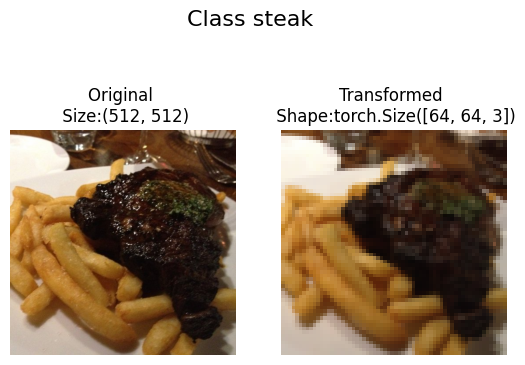

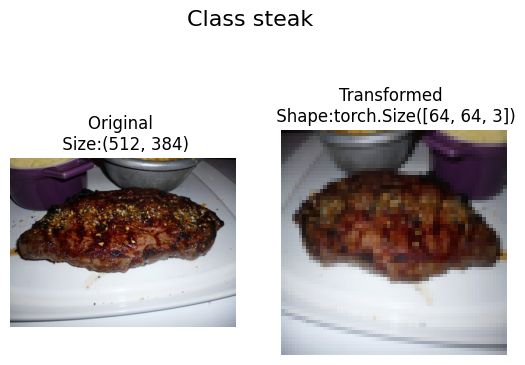

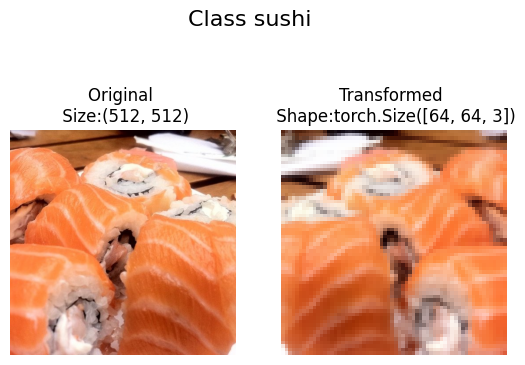

In [194]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):
    """
    Select a random image from a path of images and load /transforms
    them then plot the original vs transformed images
    """
    if seed:
        random.seed(seed)
    random_image_path=random.sample(image_paths,k=n)

    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig,ax=plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \n Size:{f.size}")
            ax[0].axis("off")

            # Transform and plot target image
            transformed_image=transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \n Shape:{transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class {image_path.parent.stem}",fontsize=16)

plot_transformed_images(image_path_list,data_transform,seed=42)

#  4.Option 1: Loading  Image data using ImageFolder
we can use `torchvision.datasets.ImageFolder` to load our data

In [195]:
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_dir,
                    transform=data_transform,
                    target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                   transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [196]:
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [197]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [198]:
len(train_data),len(test_data)

(225, 75)

In [199]:
img,label=train_data[0]
print(f" Image Tensor: {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Label: {label} ({class_names[label]})")
print(f"Label type: {type(label)}")

 Image Tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

 Original Shape:torch.Size([3, 64, 64])
 Permuted Shape:torch.Size([64, 64, 3])


Text(0.5, 1.0, 'Image Class: pizza')

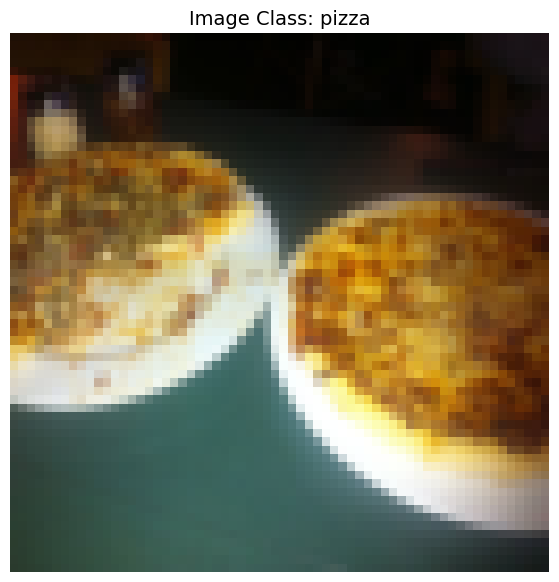

In [200]:
img_permute=img.permute(1,2,0)
img_permute.shape

print(f" Original Shape:{img.shape}")
print(f" Permuted Shape:{img_permute.shape}")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(f"Image Class: {class_names[label]}", fontsize=14)

## 4.1 Turn loaded data images into `DataLoader`'s

A `DataLoader` is f=going to help us convert `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [201]:
# turn train and test datasets into dataloader

from torch.utils.data import DataLoader
import os
BATCH_SIZE=1

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=True
                            )

test_dataloader=DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False
                            )

train_dataloader,test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x78252d0afd60>,
 <torch.utils.data.dataloader.DataLoader at 0x78252d0ac0a0>)

In [202]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [203]:
img,label=next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


# 5 Option 2: Loading Image Data with a Custom `Dataset`

*1. Want to be able to load image from file
*2. want ot be able to get class names from datasets
*3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
*Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything , it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing code, which could be prone to errors and performance issues

In [204]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [205]:
# Instance of torchvision.dataset.ImageFolder()

train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [206]:
#Setup path for target directory
target_directory=train_dir
print(f"Target Directory: {target_directory}")

#Get the clsss names from the target dirctory
class_names_found=sorted([entry.name for entry in list(os.scandir(target_directory))])
print(f"Class Names Found: {class_names_found}")

Target Directory: data/pizza_steak_sushi/train
Class Names Found: ['pizza', 'steak', 'sushi']


In [207]:
def find_classes(directory:str)-> Tuple[List[str],Dict[str,int]]:
    """
    Finds the class folder names in a target directory .
    """
    # 1. get the class names by scanning the target directory
    classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2.  Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index to class
    class_to_idx={class_name:i for i,class_name in enumerate(classes)}
    return classes,class_to_idx

In [208]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`
To create our own custom dataset , we want to :    

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
* paths - paths of our images
* transform - the transform we'd like to use
* classes - a list of the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the` __getitem()__ `method to return a given sample when passed an index


In [209]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

#1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    #2. Initialize our custom Data
    def __init__(self,
                  targ_dir:str,
                  transform=None):
        #3. Create class attributes
        #get all the image paths
        self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        #setup transorm
        self.transform=transform
        #create classes and class_to_idx attributes
        self.classes,self.class_to_idx=find_classes(targ_dir)

    #4. Create a function to load images
    def load_image(self,index:int)->Image.Image:
        """Opens and loads an image by index."""
        image_path=self.paths[index]
        return Image.open(image_path)

    #5. Overwrite the __len__() method
    def __len__(self)->int :
        return len(self.paths)

    #6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self,index:int)-> Tuple[torch.Tensor,int]:
        """Returns a sample at the given index. data and  label (X,y)"""
        img=self.load_image(index)
        class_name=self.paths[index].parent.name
        class_idx=self.class_to_idx[class_name]

        #Transform if necessary
        if self.transform:
            return self.transform(img),class_idx #return data and label(X,y)
        else:
            return img,class_idx #return untransformed data and label(X,y)

In [210]:
#Create a transform
from torchvision import transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [211]:
train_data_custom=ImageFolderCustom(targ_dir=train_dir,
                                    transform=train_transform)
test_data_custom=ImageFolderCustom(targ_dir=test_dir,
                                    transform=test_transform)

In [212]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x78252d0af430>,
 <__main__.ImageFolderCustom at 0x78252d0ad750>)

In [213]:
len(train_data_custom),len(test_data_custom)

(225, 75)

In [214]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [215]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [216]:
print(train_data.classes==train_data_custom.classes)

True


### 5.3 Create a function to display random Images
1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indexes and plot them with matploltib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [217]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n:int=10,
                          display_shape:bool=True,
                          seed :int=None):
    #2. Adjust display if n is to high
    if n>10:
        n=10
        display_shape=False
        print(f"For display, purposes, n shouldn't be greater than 10, setting to 10 and removing shape display.")

    #3. Setup seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx=random.sample(range(len(dataset)),k=n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))
    plt.subplots_adjust(hspace=0.5)

    # 6. Loop through random indexes and plot them with matplotlib
    for i,targ_sample in enumerate(random_samples_idx):
        targ_image,targ_label=dataset[targ_sample][0],dataset[targ_sample][1]

        #7. Adjust image tensor shape for matplotlib
        targ_image_adjust=targ_image.permute(1,2,0)

        #Plot adjusted samples
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title=f"Class: {classes[targ_label]}"
            if display_shape:
                title+=f"\nShape: ({targ_image_adjust.shape})"
            plt.title(title)

For display, purposes, n shouldn't be greater than 10, setting to 10 and removing shape display.


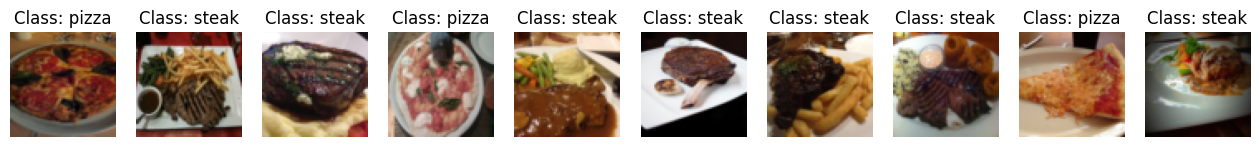

In [218]:
#display random Images from the ImageFolder created Dataset
display_random_images(train_data_custom,
                      classes=train_data_custom.classes,
                      n=20,
                      seed=42)

### 5.4 Turn custom loaded images int `DataLoader`'s

In [219]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
train_dataloader_custom=DataLoader(dataset=train_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=True)

test_dataloader_custom=DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [220]:
# Get image and label
img,label=next(iter(train_dataloader_custom))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


# 6.Other forms of transforms(data Augmentaion)

In [221]:
# Lets look at trivialaugment
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()])
test_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()])

In [222]:
# Get all image paths
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/75537.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2087958.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2878151.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2648423.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/97656.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2629750.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3518960.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2614189.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2603058.jpg')]

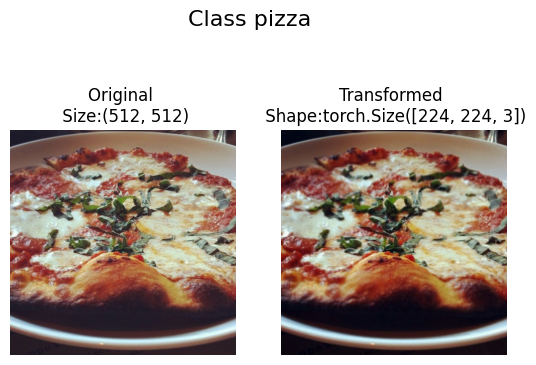

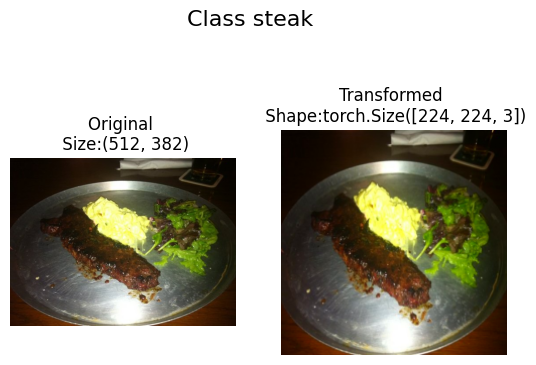

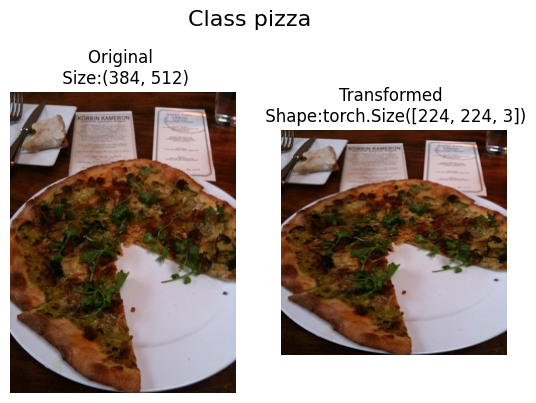

In [224]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                         transform=train_transform,
                         n=3,
                         seed=None)

# 7.Model 0 : TinyVGG without data augmention

## 7.1 Create transforms and loading data for model 0

In [225]:
#Create a simple transform
simple_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [226]:
# Load and transform data
from torchvision import datasets

train_data_simple=datasets.ImageFolder(root=train_dir,
                                       transform=simple_transform)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

In [227]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_data_loader=DataLoader(dataset=train_data_simple,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS)

test_data_loader=DataLoader(dataset=test_data_simple,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [254]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int)->None:
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                       out_features=output_shape)
        )

    def forward(self,x):
        x=self.conv_block_1(x)
        #print(x.shape)
        x=self.conv_block_2(x)
        #print(x.shape)
        x=self.classifier(x)
        #print(x.shape)
        return x

In [255]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(train_data_simple.classes)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [256]:
image_batch,label_batch=next(iter(train_data_loader))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [257]:

model_0(image_batch)


tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [258]:
try :
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0,input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()`
* `test_step()`


In [260]:
# Create train_step()

def train_step(
        model:nn.Module,
        dataloader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        optimizer:torch.optim.Optimizer,
        device=device
):
    #Put the model in train mode
    model.train()

    # setup train loss and train accuracy values
    train_loss,train_acc=0,0

    #Loop through the dataloader data batches
    for batch, (X,y) in enumerate(dataloader):
        #send data to the target device
        X,y=X.to(device),y.to(device)

        # 1. Forward pass
        y_pred=model(X)

        # 2. Calculate the loss
        loss=loss_fn(y_pred,y)
        train_loss+=loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss=train_loss/len(dataloader)
    train_acc=train_acc/len(dataloader)
    return train_loss,train_acc

In [262]:
# Create a test step
def test_step(
        model:nn.Module,
        dataloader:torch.utils.data.DataLoader,
        loss_fn:torch.nn.Module,
        device=device
):
    #Put the model in eval mode
    model.eval()

    # setup test loss and test accuracy values
    test_loss,test_acc=0,0

    # Turn on inference_mode
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            #Send data to the target device
            X,y=X.to(device),y.to(device)

            #Forward pass
            test_pred_logits=model(X)

            #Calculate the loss
            loss=loss_fn(test_pred_logits,y)
            test_loss+=loss.item()

            #Calculate the accuracy
            test_pred_labels=test_pred_logits.argmax(dim=1)
            test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss=test_loss/len(dataloader)
    test_acc=test_acc/len(dataloader)
    return test_loss,test_acc